In [69]:
import os
import torch
from torch import nn as nn
import math
from glob import glob
from torchinfo import summary
from torch_snippets import *
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 
import gc
from torch.autograd import Variable

import random
random.seed(23718)

#is GPU available?
gpu = torch.cuda.is_available()

#defining device where to to the computation
device = torch.device(0) if gpu else torch.device('cpu')

In [70]:
# Set the folder with the samples (images) that compose a dataset and the number of classes

orig_dir   = '../data/raw/SAMPLES/fishes/'
mask_dir   = '../data/raw/SAMPLES/mask/'
nclasses   = 9

# Set the desired image size for rescaling and maximum value for normalization

width       = 224 
height      = 168
nchannels   = 3
maxval      = 255. 
input_shape = (nchannels,height,width)

# Set the percentages of samples that will be used for training, validation and test. 

train_perc = 0.40
valid_perc = 0.30
test_perc  = 0.30

# Create training, validation, and test sets.

data = glob(orig_dir+"/*.png") # it returns a list of image filenames
mask_data = glob(mask_dir+"/*.png") # it returns a list of image mask filenames

num_train_samples = int(len(data) * train_perc)
num_valid_samples = int(len(data) * valid_perc)  
num_test_samples  = len(data) - num_train_samples - num_valid_samples 
np.random.shuffle(data) # randomly change the order of the filenames in data
trainset = data[:num_train_samples] 
validset = data[num_train_samples:num_train_samples+num_valid_samples]
testset  = data[num_train_samples+num_valid_samples:]

mask_trainset = [a.replace('fishes', 'mask') for a in trainset]
mask_validset = [a.replace('fishes', 'mask') for a in validset]
mask_testset  = [a.replace('fishes', 'mask') for a in testset]

# Set output model name

model_name  = 'FishCNN.pth'

In [71]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized, 
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters. 

prep = transforms.Compose([
    transforms.Resize((height, width), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor()#,
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation, 
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 
# of epochs, we are actually implementing data augmentation. 

_aug = transforms.Compose([
    transforms.Resize((height, width), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor()#,
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation, 
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 
# of epochs, we are actually implementing data augmentation. 

aug = transforms.Compose([
    transforms.Resize((height * 2, width * 2), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR, 
                            fill=0),
    transforms.Resize((height, width), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor()#,
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

In [72]:
# Create an image dataset by applying one of the preprocessing transformations above

class ImageDataset(Dataset): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset, mask_dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset      = dataset
        self.mask_dataset = mask_dataset
        self.targets      = [int(str(x).split(os.sep)[-1].split("_")[0]) for x in self.dataset]
        self.transform    = transform
    def __len__(self): return len(self.dataset)        
    def __getitem__(self, ix): # returns the item at position ix 
        filename      = self.dataset[ix]
        mask_filename = self.mask_dataset[ix]
        target        = self.targets[ix]
        image         = Image.open(filename) # It is a PIL image
        mask          = Image.open(mask_filename) # It is a PIL image
        if (self.transform is not None):
            image = self.transform(image)
            mask  = self.transform(mask)
        else: # just reshape the image as a tensor with nchannels, height, width
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()                  
            mask = torch.from_numpy(np.array(mask)).float() #.permute(2,0,1).float()                  
        return(image, mask, target) 

In [73]:
trainset_data = ImageDataset(trainset, mask_trainset, aug) # verify the difference with and wothout data augmentation
validset_data = ImageDataset(validset, mask_validset, prep)
testset_data  = ImageDataset(testset, mask_testset, prep)

Number of images: 36

Image

(168, 224, 3)

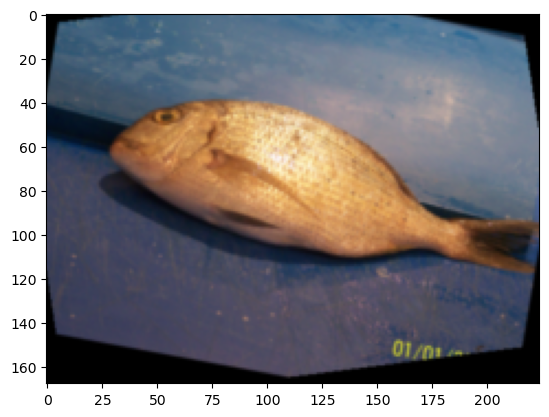

Class of the image:  5

Mask

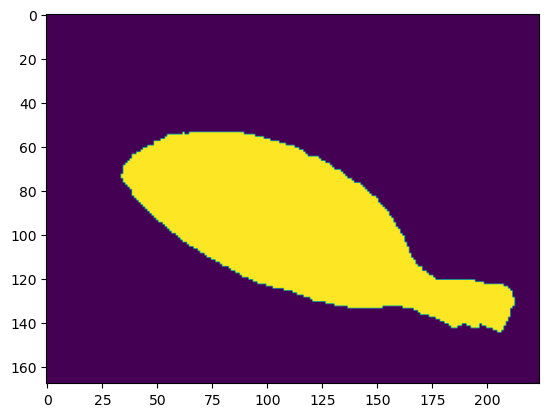

Mask applied to image

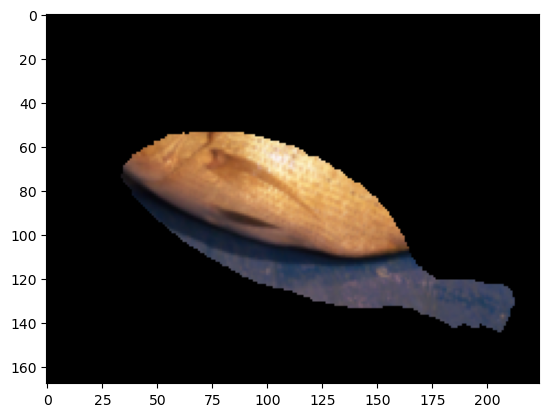

In [74]:

print("Number of images:", len(trainset_data))

image, mask, target = trainset_data[12] # it executes getitem

print('Image')
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print(image.shape)
plt.imshow(image)
plt.show()
print("Class of the image: ", target+1)

print('Mask')
mask     = mask.permute(1,2,0).numpy()
mask     = 255*(mask - np.min(mask))/(np.max(mask)-np.min(mask))
mask     = mask.astype('uint8')
plt.imshow(mask)
plt.show()

print('Mask applied to image')
plt.imshow(255 * (image * mask))
plt.show()


In [75]:
batchsize = 2
trainload = DataLoader(trainset_data, batch_size=batchsize, shuffle=True)
testload  = DataLoader(testset_data, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset_data, batch_size=batchsize, shuffle=True)

inspect(next(iter(trainload))) # inspect a couple of items in the batches

══════════════════════════════════════════════════════════════════

list of 3 items

Tensor  Shape: torch.Size([2, 3, 168, 224])     Min: 0.000      Max: 1.000      Mean: 0.345     dtype: 
torch.float32 @ cpu

Tensor  Shape: torch.Size([2, 1, 168, 224])     Min: 0.000      Max: 1.000      Mean: 0.263     dtype: 
torch.float32 @ cpu

Tensor  Shape: torch.Size([2])  Min: 1.000      Max: 8.000      Mean: 4.500     dtype: torch.int64 @ cpu

══════════════════════════════════════════════════════════════════

In [251]:
# a convolutional block
def conv_block_default(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(
        #defining convolutional layer 
        nn.Conv2d(in_channels=nchannels_in, out_channels=nchannels_out, kernel_size=(3, 3),
                  stride=1, padding=1, bias=False),
        #defining a batch normalization layer, which dismisses the need for bias in the previous conv layer
        nn.BatchNorm2d(num_features=nchannels_out),
        #defining activation layer
        nn.ReLU(),
        #defining a pooling layer
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )

def conv_block_tanh(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(
        nn.Conv2d(in_channels=nchannels_in, out_channels=nchannels_out, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=stride_val)
    )
    
class FishCNN(nn.Module):

    def __init__(self, input_shape, num_classes):
        super(FishCNN, self).__init__()
        
        #defining feature extractor
        self.features = nn.Sequential(
            conv_block_default(input_shape[0],32,2),
            conv_block_default(32,64,2),
            conv_block_default(64,256,2),
            conv_block_tanh(256, 512, 2)
        )

        #defining classifier
        self.classifier = nn.Sequential(
            # RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x150528 and 602112x64)
            
            #nn.Linear(in_features=input_shape[1]//4*input_shape[2]//4*256, out_features=64, bias=True),
            nn.Linear(in_features=49152 , out_features=256, bias=True),
            nn.ReLU(),
            nn.Dropout(0.20),
            #nn.Linear(64, nclasses)
            nn.Linear(in_features=256, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=nclasses)
        )

        #initialize weights
        self._initialize_weights()

    def forward(self, x, mask): # x = imagem
       #extracts features
        x = self.features(x)
        
        x_shape = x.shape
        print(f"batch_size: {x_shape[0]}, channels: {x_shape[1]}, height: {x_shape[2]}, width: {x_shape[3]}")
        mask_shape = mask.shape
        print(f"batch_size: {mask_shape[0]}, channels: {mask_shape[1]}, height: {mask_shape[2]}, width: {mask_shape[3]}")
        
        mask_tensor = torch.squeeze(mask, (0, 1))
        print(mask_tensor.shape)
        # convert tensor to numpy array
        img = mask.squeeze(0).detach().cpu().numpy()
        print(img.shape) #(16, 3, 32, 32)
        img = img[0, :,:,:].transpose(1,2,0)
        print(img.shape)
        mask_pil = Image.fromarray(img)
        mask_pil = mask_pil.resize((x_shape[2], x_shape[3]))
        plt.imshow(mask_pil, cmap='gray')
        plt.show()
        #TODO: APPLY MASK HERE
        # 0) Redimensionar o tamanho da máscara
        # 1) Adicionar uma dimensão no índice 1 da imagem (channels)
        # 2) Replicar para que a imagem e o mask tenham o mesmo número de canais
        # mask[0] = batch
        #     1  = altura
        #     2  = largura
        # 
        #transforms outputs into a 2D tensor
        x = torch.flatten(x, start_dim=1)

        #classifies features
        y = self.classifier(x)
        # TODO: remover  
        y = F.sigmoid(y)
        return y
  
    def _initialize_weights(self):
        #for each submodule of our network
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels    
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))

                if m.bias is not None:
                    #initialize bias with 0 
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                #initialize bias with 0 
                    m.bias.data.zero_()

In [252]:
model = FishCNN(input_shape, nclasses).to(device)
print(model)
#summary(model)
#summary(model, input_data=[(3,244,168), (2,244,168)], dtypes=[torch.int, torch.int], depth=1)

FishCNN(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1))
      (1): Tanh()
      (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=49152, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=120, bias=True)
    (4): Tanh()
    (5): Linear(in_features=120, out_features=84, bias=True)
    (6): Tanh()
    (7): Linear(in_features=84, out_features=9, bias=True)
  )
)

In [253]:
def Criterion(model, preds, targets):
    ce            = nn.CrossEntropyLoss().to(device)
    loss          = ce(preds, targets.long()) 
    # add l2_regularization            
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param,2)
    loss += 0.0001*l2_regularization # 0.0001 is the weight_decay
    # compute mean accuracy in the batch
    pred_labels   = torch.max(preds, 1)[1] # same as argmax
    acc           = torch.sum(pred_labels == targets.data)
    n             = pred_labels.size(0)
    acc           = acc/n
    return loss, acc


criterion = Criterion

In [254]:
optimizer    = optim.Adam(model.parameters(), lr=1e-5)
# gamma=0.1 is a multiplicative factor for lr decay at every epoch
# lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.1)
# gamma=0.1 is a multiplicative factor for lr decay at every step_size=number of epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [255]:
#del trainset, validset, testset
gc.collect()
torch.cuda.empty_cache()

In [256]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, mask, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims, mask) #processo do forward
    loss, acc = criterion(model, preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, mask, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims, mask)
    loss, acc = criterion(model, preds, targets)
    return loss.item(), acc.item()

In [257]:
%%time
# initializing variables
n_epochs = 1
log      = Report(n_epochs)

# starting training and validation
for ex in range(n_epochs):
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc = train_batch(model, data, optimizer, criterion, device)
        #report results for the batch
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    N = len(validload)
    for bx, data in enumerate(validload):
        loss, acc = validate_batch(model, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (ex+1)%10==0: log.report_avgs(ex+1)
    #count epochs for auto-adjusting the learning rate
    lr_scheduler.step()

batch_size: 2, channels: 512, height: 8, width: 12

batch_size: 2, channels: 1, height: 168, width: 224

torch.Size([2, 168, 224])

(2, 1, 168, 224)

(168, 224, 1)

TypeError: Cannot handle this data type: (1, 1, 1), <f4

<Axes: >

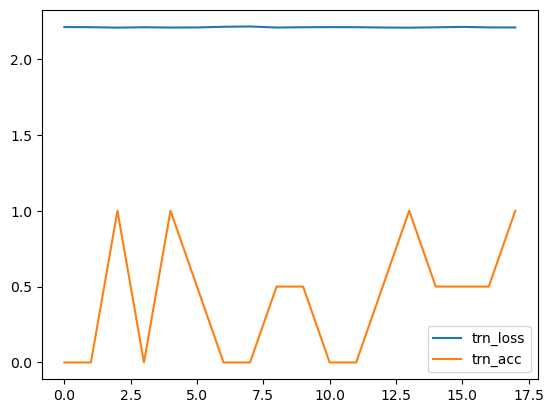

In [84]:
df0 = pd.DataFrame()
for i in ['trn_loss','trn_acc']:#, 'trn_acc','val_acc']:
    f = open(f"{i}.csv", 'w')
    for j in log.history(i):
        f.write(str(j)+ '\n')
    f.close()
    df0[i] = log.history(i)
df0.plot()

<Axes: >

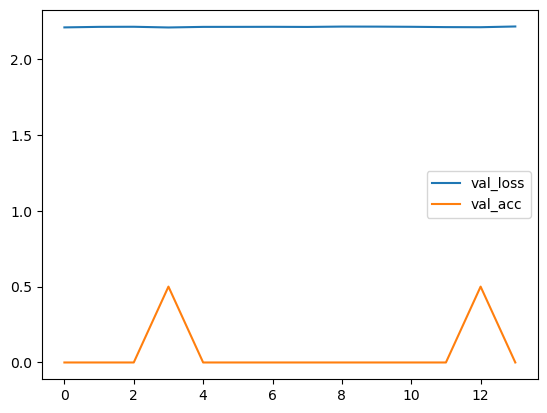

In [85]:
df0 = pd.DataFrame()
for i in ['val_loss','val_acc']:#, 'trn_acc','val_acc']:
    f = open(f"{i}.csv", 'w')
    for j in log.history(i):
        f.write(str(j)+ '\n')
    f.close()
    df0[i] = log.history(i)
df0.plot()

100%|█████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 25488.17it/s]


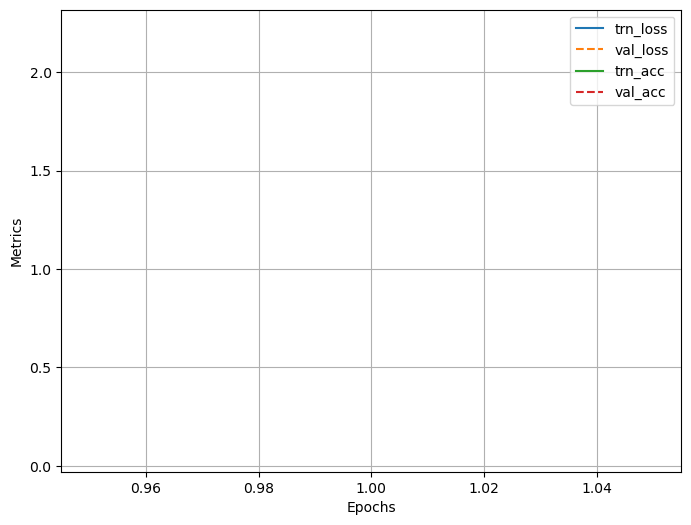

100%|█████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 64179.27it/s]


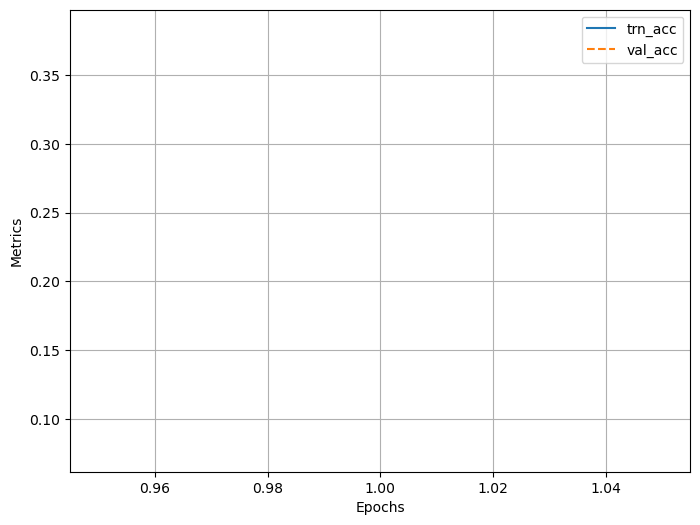

In [86]:
log.plot_epochs(['trn_loss','val_loss', 'trn_acc','val_acc'])
log.plot_epochs(['trn_acc','val_acc'])

In [87]:
def Test(model, testload, criterion, device):
    N = len(testload)
    mean_loss = 0
    mean_acc  = 0
    for bx, data in enumerate(testload):
        loss, acc  = validate_batch(model, data, criterion, device)
        mean_loss += loss
        mean_acc  += acc
    
    mean_loss = mean_loss / N
    mean_acc  = mean_acc / N
    return(mean_loss, mean_acc)

(loss, acc) = Test(model, testload, criterion, device)
print('Loss: {:.6f} Acc: {:.6f}'.format(loss,acc))

batch_size: 2, channels: 512, height: 8, width: 12

torch.Size([2, 1, 168, 224])

batch_size: 2, channels: 512, height: 8, width: 12

torch.Size([2, 1, 168, 224])

batch_size: 2, channels: 512, height: 8, width: 12

torch.Size([2, 1, 168, 224])

batch_size: 2, channels: 512, height: 8, width: 12

torch.Size([2, 1, 168, 224])

batch_size: 2, channels: 512, height: 8, width: 12

torch.Size([2, 1, 168, 224])

batch_size: 2, channels: 512, height: 8, width: 12

torch.Size([2, 1, 168, 224])

batch_size: 2, channels: 512, height: 8, width: 12

torch.Size([2, 1, 168, 224])

batch_size: 2, channels: 512, height: 8, width: 12

torch.Size([2, 1, 168, 224])

batch_size: 2, channels: 512, height: 8, width: 12

torch.Size([2, 1, 168, 224])

batch_size: 2, channels: 512, height: 8, width: 12

torch.Size([2, 1, 168, 224])

batch_size: 2, channels: 512, height: 8, width: 12

torch.Size([2, 1, 168, 224])

batch_size: 2, channels: 512, height: 8, width: 12

torch.Size([2, 1, 168, 224])

batch_size: 2, channels: 512, height: 8, width: 12

torch.Size([2, 1, 168, 224])

batch_size: 1, channels: 512, height: 8, width: 12

torch.Size([1, 1, 168, 224])

Loss: 2.211037 Acc: 0.214286

In [88]:
torch.save(model.to('cpu').state_dict(), model_name)